In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta
from dateutil.easter import easter
import matplotlib.pyplot as plt
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from pandas.tseries.frequencies import to_offset
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split

In [2]:
monthly_data = pd.read_csv("monthly_data.csv")

/Users/ciara/Desktop/Final Project/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/ciara/Desktop/Final Project/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/ciara/Desktop/Final Project/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/ciara/Desktop/Final Project/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/ciara/Desktop/Final Project/.venv/lib/python3.10/site-package

模型评估指标（基于价格）:
RMSE: 36.5061
MAE:  1045.9697
MAPE: 13.37%


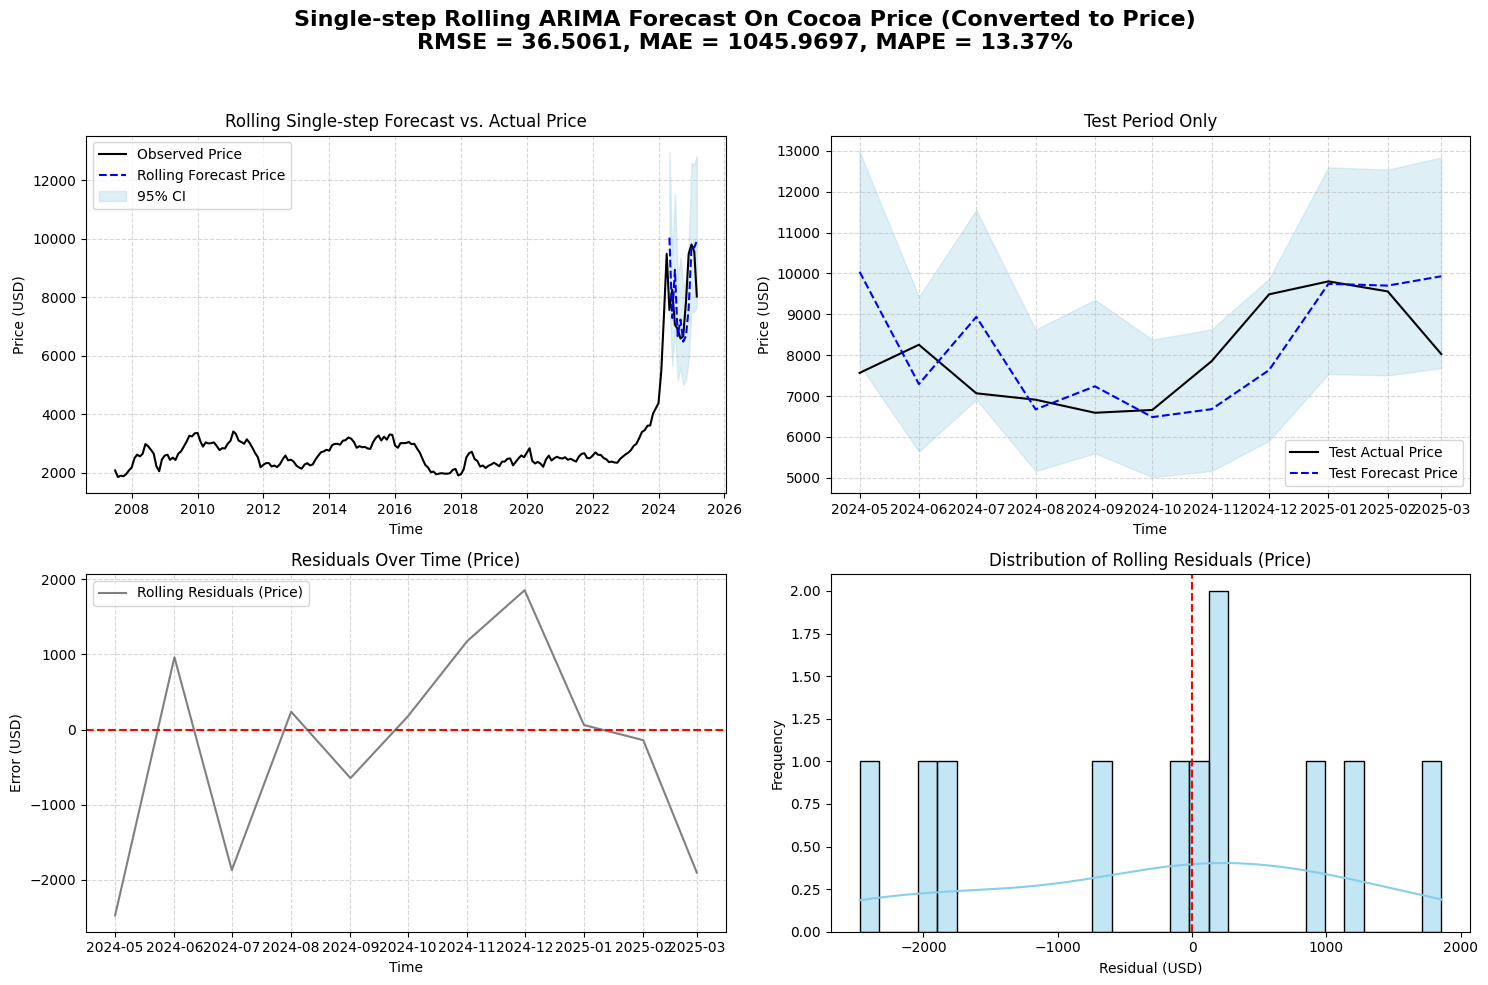

In [3]:
monthly_data["Month"] = pd.to_datetime(monthly_data["Month"], errors='coerce')

monthly_data_ts = monthly_data.set_index("Month")

return_series = monthly_data_ts["log_return_rate"].dropna()

price_series = monthly_data_ts["Price_NY"]

n = len(return_series)
train_size = int(n * 0.95)
test_series = return_series.iloc[train_size:]

rolling_forecasts = {}   
rolling_residuals = {}  

for test_date in test_series.index:
    current_train_data = return_series.loc[:test_date].iloc[:-1]
    arima_model = ARIMA(current_train_data, order=(1, 0, 1))
    arima_result = arima_model.fit()
    forecast_log_return = arima_result.forecast(steps=1).iloc[0]
    rolling_forecasts[test_date] = forecast_log_return
    actual_log_return = return_series.loc[test_date]
    rolling_residuals[test_date] = actual_log_return - forecast_log_return

rolling_forecast_series = pd.Series(rolling_forecasts)

predicted_prices = {}
for test_date, forecast_log_return in rolling_forecast_series.items():
    prev_price = price_series[price_series.index < test_date].iloc[-1]
    predicted_prices[test_date] = prev_price * np.exp(forecast_log_return)

predicted_price_series = pd.Series(predicted_prices)

true_price_series = price_series.loc[rolling_forecast_series.index]

rmse_price = np.sqrt(root_mean_squared_error(true_price_series, predicted_price_series))
mae_price = mean_absolute_error(true_price_series, predicted_price_series)
mape_price = mean_absolute_percentage_error(true_price_series, predicted_price_series) * 100

print("模型评估指标（基于价格）:")
print(f"RMSE: {rmse_price:.4f}")
print(f"MAE:  {mae_price:.4f}")
print(f"MAPE: {mape_price:.2f}%")

resid_std = pd.Series(rolling_residuals).std()
z = 1.96  # 对应 95% 置信水平

ci_upper = {}
ci_lower = {}
for test_date, forecast_log_return in rolling_forecast_series.items():
    prev_price = price_series[price_series.index < test_date].iloc[-1]
    ci_upper[test_date] = prev_price * np.exp(forecast_log_return + z * resid_std)
    ci_lower[test_date] = prev_price * np.exp(forecast_log_return - z * resid_std)

ci_upper_series = pd.Series(ci_upper)
ci_lower_series = pd.Series(ci_lower)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

fig.suptitle(
    f"Single-step Rolling ARIMA Forecast On Cocoa Price (Converted to Price)\n"
    f"RMSE = {rmse_price:.4f}, MAE = {mae_price:.4f}, MAPE = {mape_price:.2f}%",
    fontsize=16, weight="bold"
)

axes[0, 0].plot(price_series, label="Observed Price", color="black")
axes[0, 0].plot(predicted_price_series, label="Rolling Forecast Price", color="blue", linestyle="--")
axes[0, 0].fill_between(predicted_price_series.index, ci_lower_series, ci_upper_series, 
                        color="lightblue", alpha=0.4, label="95% CI")
axes[0, 0].set_title("Rolling Single-step Forecast vs. Actual Price", fontsize=12)
axes[0, 0].set_xlabel("Time")
axes[0, 0].set_ylabel("Price (USD)")
axes[0, 0].legend()
axes[0, 0].grid(True, linestyle="--", alpha=0.5)

axes[0, 1].plot(true_price_series, label="Test Actual Price", color="black")
axes[0, 1].plot(predicted_price_series, label="Test Forecast Price", color="blue", linestyle="--")
axes[0, 1].fill_between(predicted_price_series.index, ci_lower_series, ci_upper_series, 
                        color="lightblue", alpha=0.4)
axes[0, 1].set_title("Test Period Only", fontsize=12)
axes[0, 1].set_xlabel("Time")
axes[0, 1].set_ylabel("Price (USD)")
axes[0, 1].legend()
axes[0, 1].grid(True, linestyle="--", alpha=0.5)

price_residuals = true_price_series - predicted_price_series
axes[1, 0].plot(price_residuals, label="Rolling Residuals (Price)", color="gray")
axes[1, 0].axhline(0, color="red", linestyle="--")
axes[1, 0].set_title("Residuals Over Time (Price)", fontsize=12)
axes[1, 0].set_xlabel("Time")
axes[1, 0].set_ylabel("Error (USD)")
axes[1, 0].legend()
axes[1, 0].grid(True, linestyle="--", alpha=0.5)

sns.histplot(price_residuals, bins=30, kde=True, color="skyblue", ax=axes[1, 1])
axes[1, 1].axvline(0, color="red", linestyle="--")
axes[1, 1].set_title("Distribution of Rolling Residuals (Price)", fontsize=12)
axes[1, 1].set_xlabel("Residual (USD)")
axes[1, 1].set_ylabel("Frequency")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [20]:
print(monthly_data["Month"].head())
print(monthly_data["Month"].dtype)

0    2007-07-01
1    2007-08-01
2    2007-09-01
3    2007-10-01
4    2007-11-01
Name: Month, dtype: object
object


c:\Users\30467\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\30467\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\30467\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


模型评估指标（价格层面）:
RMSE: 49.4360
MAE:  2212.0778
MAPE: 30.03%


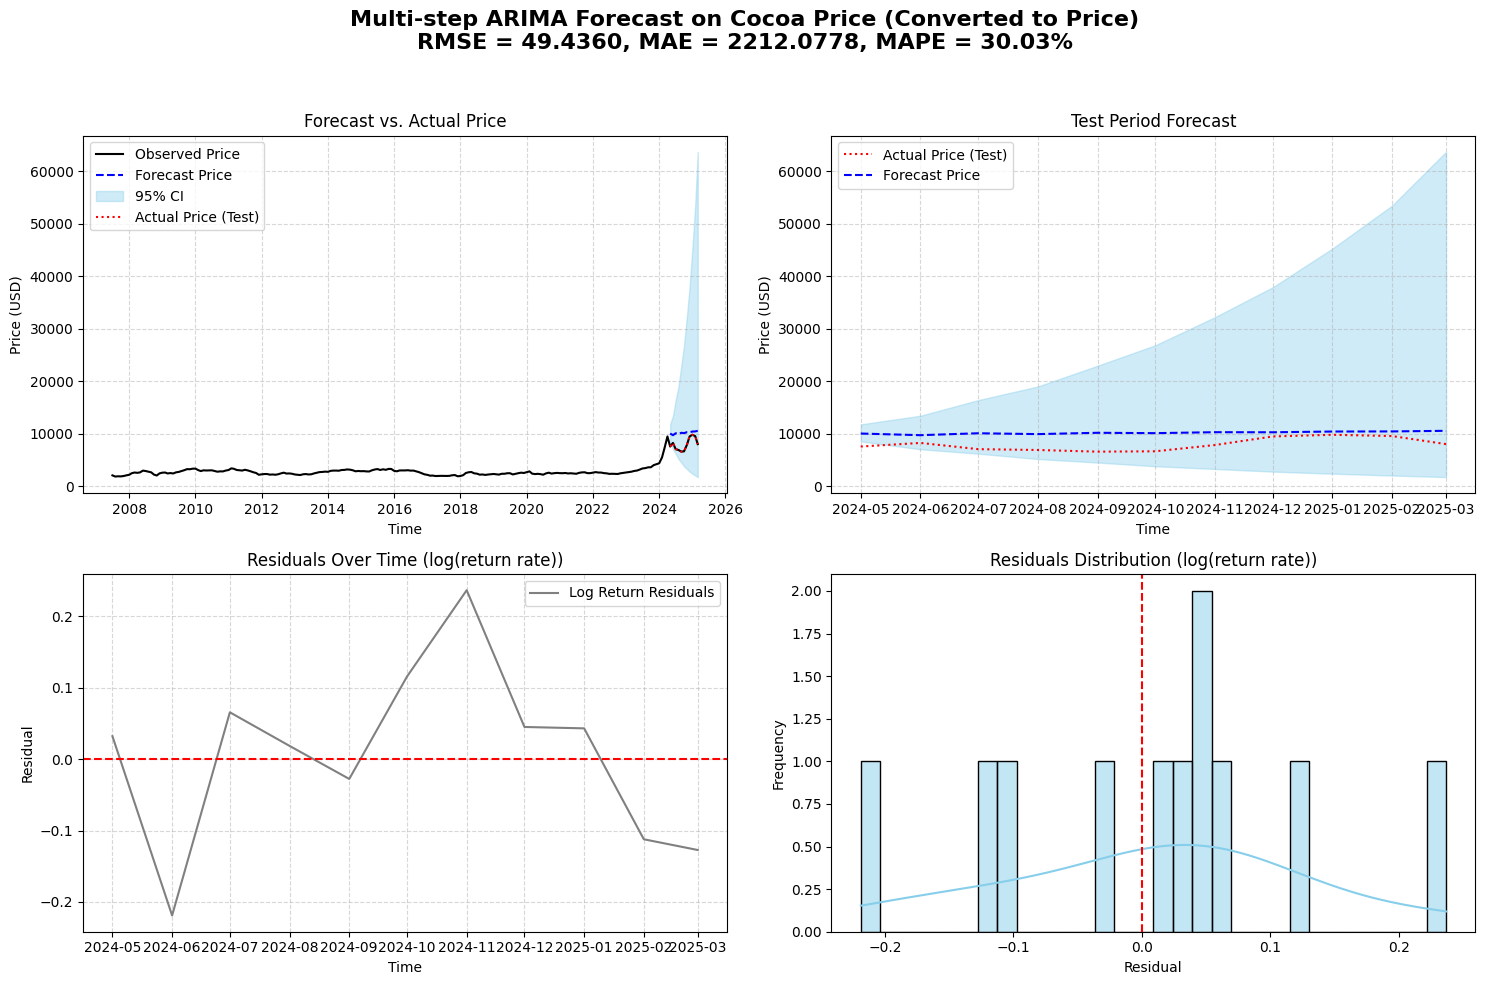

In [29]:
monthly_data["Month"] = pd.to_datetime(monthly_data["Month"], errors='coerce')
monthly_data_ts = monthly_data.set_index("Month")
price_series = monthly_data_ts["Price_NY"]
return_series = monthly_data_ts["log_return_rate"].dropna()

# 数据划分
n = len(return_series)
train_size = int(n * 0.95)
train_return_series = return_series.iloc[:train_size]
test_return_series = return_series.iloc[train_size:]
test_steps = len(test_return_series)

# ARIMA 模型拟合（对数收益率空间）
arima_model = ARIMA(train_return_series, order=(1, 0, 1))
arima_result = arima_model.fit()

# 多步预测
forecast_object = arima_result.get_forecast(steps=test_steps)
forecast_return_mean = forecast_object.predicted_mean      
forecast_return_conf_int = forecast_object.conf_int(alpha=0.05) 

# 以训练集最后一个价格作为起点，利用累计预测的对数收益率计算价格预测
base_price = price_series.loc[train_return_series.index[-1]]
cum_forecast_return = forecast_return_mean.cumsum()
predicted_price = base_price * np.exp(cum_forecast_return)

# 计算预测置信区间（累加置信区间下界和上界）
lower_cumsum = forecast_return_conf_int.iloc[:, 0].cumsum()
upper_cumsum = forecast_return_conf_int.iloc[:, 1].cumsum()
ci_lower_price = base_price * np.exp(lower_cumsum)
ci_upper_price = base_price * np.exp(upper_cumsum)

actual_prices = price_series.loc[test_return_series.index]

# 评价指标（价格层面）
rmse_price = np.sqrt(root_mean_squared_error(actual_prices, predicted_price))
mae_price = mean_absolute_error(actual_prices, predicted_price)
mape_price = mean_absolute_percentage_error(actual_prices, predicted_price) * 100

print("模型评估指标（价格层面）:")
print(f"RMSE: {rmse_price:.4f}")
print(f"MAE:  {mae_price:.4f}")
print(f"MAPE: {mape_price:.2f}%")

# 计算对数收益率残差（测试期实际 vs. 预测）
log_residuals = test_return_series - forecast_return_mean

# 绘图
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle(
    f"Multi-step ARIMA Forecast on Cocoa Price (Converted to Price)\n"
    f"RMSE = {rmse_price:.4f}, MAE = {mae_price:.4f}, MAPE = {mape_price:.2f}%",
    fontsize=16, weight="bold"
)

# 图1：全数据范围内观察值与预测价格及置信区间
axes[0, 0].plot(price_series, label="Observed Price", color="black")
axes[0, 0].plot(predicted_price.index, predicted_price, label="Forecast Price", color="blue", linestyle="--")
axes[0, 0].fill_between(predicted_price.index, ci_lower_price, ci_upper_price, 
                        color="skyblue", alpha=0.4, label="95% CI")
axes[0, 0].plot(actual_prices.index, actual_prices, label="Actual Price (Test)", color="red", linestyle="dotted")
axes[0, 0].set_title("Forecast vs. Actual Price", fontsize=12)
axes[0, 0].set_xlabel("Time")
axes[0, 0].set_ylabel("Price (USD)")
axes[0, 0].legend()
axes[0, 0].grid(True, linestyle="--", alpha=0.5)

# 图2：仅测试期间的价格预测对比
axes[0, 1].plot(actual_prices, label="Actual Price (Test)", color="red", linestyle="dotted")
axes[0, 1].plot(predicted_price.index, predicted_price, label="Forecast Price", color="blue", linestyle="--")
axes[0, 1].fill_between(predicted_price.index, ci_lower_price, ci_upper_price, 
                        color="skyblue", alpha=0.4)
axes[0, 1].set_title("Test Period Forecast", fontsize=12)
axes[0, 1].set_xlabel("Time")
axes[0, 1].set_ylabel("Price (USD)")
axes[0, 1].legend()
axes[0, 1].grid(True, linestyle="--", alpha=0.5)

# 图3：对数收益率残差随时间变化
axes[1, 0].plot(log_residuals, label="Log Return Residuals", color="gray")
axes[1, 0].axhline(0, color="red", linestyle="--")
axes[1, 0].set_title("Residuals Over Time (log(return rate))", fontsize=12)
axes[1, 0].set_xlabel("Time")
axes[1, 0].set_ylabel("Residual")
axes[1, 0].legend()
axes[1, 0].grid(True, linestyle="--", alpha=0.5)

# 图4：对数收益率残差分布直方图
sns.histplot(log_residuals, bins=30, kde=True, color="skyblue", ax=axes[1, 1])
axes[1, 1].axvline(0, color="red", linestyle="--")
axes[1, 1].set_title("Residuals Distribution (log(return rate))", fontsize=12)
axes[1, 1].set_xlabel("Residual")
axes[1, 1].set_ylabel("Frequency")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
